This work was done on Google Colaboratory.

# Boilerplate Code and Preprocessing


Importing some libraries and packages to make our work easier: 

In [0]:
from google.colab import files
import numpy as np
import torch
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

Checking if GPU is available. GPUs enable us to make our computations significantly faster.

In [2]:
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

Getting datasets from the Google Drive link.

In [3]:
!gdown https://drive.google.com/uc?id=1-mujHxt2HEdmo6C4wAWW5k88d3YEV9XN
!gdown https://drive.google.com/uc?id=1mhweZvAIELxWq522Q8QhSGDzkXzy_Wxq

Downloading...
From: https://drive.google.com/uc?id=1-mujHxt2HEdmo6C4wAWW5k88d3YEV9XN
To: /content/all_jets_train_4D_100_percent.pkl
4.47MB [00:00, 39.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mhweZvAIELxWq522Q8QhSGDzkXzy_Wxq
To: /content/all_jets_test_4D_100_percent.pkl
100% 1.12M/1.12M [00:00<00:00, 73.9MB/s]


Reading files into Pandas dataframes. Pandas dataframes give us a glimpse into how our data is structured and "looks".

In [0]:
train=pd.read_pickle("/content/all_jets_train_4D_100_percent.pkl")
test=pd.read_pickle("/content/all_jets_test_4D_100_percent.pkl")

Training set dataframe:

In [5]:
train.head(5)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


Test set dataframe:

In [6]:
test.head(5)

,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


Calculating a few statistics and using them to standardise the data. This centers our data to mean 0 and variance 1.

In [0]:
average=train.mean(axis=0) #calculates mean for each variable/feature
deviation=train.std(axis=0) #calculates the standard deviation for each variable/features
train=(train-average)/deviation #standardising the training data
test=(test-average)/deviation #standardising the test data

Converting our raw data into DataLoader ojects for ease of training and testing:

In [0]:
tensor_trainset=utils.data.TensorDataset(torch.tensor(train.values),torch.tensor(train.values))
tensor_testset=utils.data.TensorDataset(torch.tensor(test.values),torch.tensor(test.values))
batch_size=64
trainloader=utils.data.DataLoader(tensor_trainset,batch_size=batch_size,shuffle=True)
testloader=utils.data.DataLoader(tensor_testset,batch_size=batch_size,shuffle=False)

# Defining our Neural Network Architecture

The goal of an autoencoder is to "encode" higher dimensional data into lower dimensional data. An autoencoder consists of two parts: An encoder and a decoder. 
In the case of our task, the encoder encodes our 4 dimensional data to a 3 dimensional representation. The decoder tries to reconstruct our original 4 dimensional data from the original 3 dimensional data.
This allows us to compare our reconstruction to the original data, and hence improve our encoding, in a sense.

Our encoder:

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layers=nn.Sequential(
      nn.Linear(4,256,bias=True),
      #nn.BatchNorm1d(256),             #uncomment to enable batchnorm for the network in the encoder and decoder
      nn.LeakyReLU(inplace=True),
      nn.Linear(256,128,bias=True),
      #nn.BatchNorm1d(128),
      nn.LeakyReLU(inplace=True),
      nn.Linear(128,64,bias=True),
      #nn.BatchNorm1d(64),
      nn.LeakyReLU(inplace=True),
      nn.Linear(64,3,bias=True),
    )
  def forward(self,x):
    enc=self.layers(x)
    return enc


Our decoder:

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.layers=nn.Sequential(
        nn.Linear(3,64,bias=True),
        #nn.BatchNorm1d(64),
        nn.LeakyReLU(inplace=True),
        nn.Linear(64,128,bias=True),
        #nn.BatchNorm1d(128),
        nn.LeakyReLU(inplace=True),
        nn.Linear(128,256,bias=True),
        #nn.BatchNorm1d(256),
        nn.LeakyReLU(inplace=True),
        nn.Linear(256,4,bias=True)
    )
  def forward(self,enc):
    dec=self.layers(enc)
    return dec

Combining the encoder and decoder into a single network:

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.encoder=Encoder()
    self.decoder=Decoder()
    
  def encode(self,x):
    return self.encoder(x)
  def decode(self,z):
    return self.decoder(z)
  def forward(self,x):
    enc=self.encode(x)
    dec=self.decode(enc)
    return dec


# Creating our Network and Training

Creating a neural net, and initialising various hyperparameters:

In [0]:
model=Net() #compiling, and creating an instance of our neural net
model=model.to(device)
model=model.float()
lr=1e-3 #assigning our learning rate
loss_fn=nn.MSELoss() #defining what loss function we'll be using
optimizer=torch.optim.Adam(model.parameters(),lr=lr) #efining our weight update rule
num_epochs=100 #number of epochs/iterations over our complete dataset
scheduler=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[50,80],gamma=0.1) #learning rate scheduler to modify our learning rate during training

Training loop:

In [13]:
model.train() #Set model to training mode

losses=[]
for epoch in range(1,num_epochs+1):
  total_loss=0
  for i,data in enumerate(trainloader,0):
    x,target=data
    x=x.to(device)
    x=x.float()
    target=target.to(device)
    target=target.float()
    recon=model(x)
    loss=loss_fn(recon,target)
    total_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i%500==0:
      print('[%d/%d][%d/%d]\tmse_loss: %.5f'
      %(epoch,num_epochs,i,len(trainloader),loss.item()))
  losses.append(total_loss/len(trainloader))

[1/100][0/1747]	mse_loss: 0.84241
[1/100][500/1747]	mse_loss: 0.02275
[1/100][1000/1747]	mse_loss: 0.03352
[1/100][1500/1747]	mse_loss: 0.02464
[2/100][0/1747]	mse_loss: 0.04708
[2/100][500/1747]	mse_loss: 0.01159
[2/100][1000/1747]	mse_loss: 0.04860
[2/100][1500/1747]	mse_loss: 0.02020
[3/100][0/1747]	mse_loss: 0.05587
[3/100][500/1747]	mse_loss: 0.04527
[3/100][1000/1747]	mse_loss: 0.03609
[3/100][1500/1747]	mse_loss: 0.05715
[4/100][0/1747]	mse_loss: 0.02274
[4/100][500/1747]	mse_loss: 0.01238
[4/100][1000/1747]	mse_loss: 0.03687
[4/100][1500/1747]	mse_loss: 0.03565
[5/100][0/1747]	mse_loss: 0.01754
[5/100][500/1747]	mse_loss: 0.04680
[5/100][1000/1747]	mse_loss: 0.01210
[5/100][1500/1747]	mse_loss: 0.04961
[6/100][0/1747]	mse_loss: 0.01693
[6/100][500/1747]	mse_loss: 0.03544
[6/100][1000/1747]	mse_loss: 0.01632
[6/100][1500/1747]	mse_loss: 0.02001
[7/100][0/1747]	mse_loss: 0.01293
[7/100][500/1747]	mse_loss: 0.01493
[7/100][1000/1747]	mse_loss: 0.02823
[7/100][1500/1747]	mse_loss: 

Plot for training/reconstruction loss:

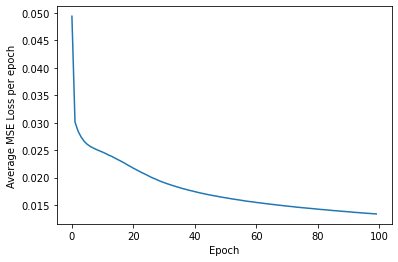

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss per epoch')
plt.plot(losses)

Finding and plotting Mean Squared Error Losses on our Test Data:

In [0]:
test_mse_losses=[]
for data in testloader:
  x,target=data
  x=x.to(device)
  x=x.float()
  target=target.to(device)
  target=target.float()
  recon=model(x)
  loss=loss_fn(recon,target)
  test_mse_losses.append(loss.item()/batch_size)

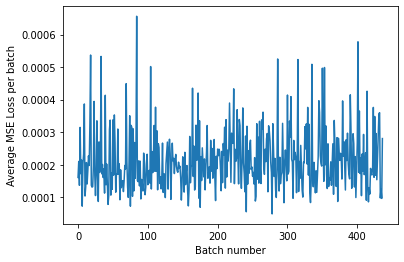

In [17]:
plt.xlabel('Batch number')
plt.ylabel('Average MSE Loss per batch')
plt.plot(test_mse_losses)

# Evaluation and Analysis

In [0]:
model.eval() #Set model to test mode
model.to('cpu')
average=train.mean(axis=0)
deviation=train.std(axis=0)

data=torch.tensor(test.values) 
recon=model(data.float()).detach().numpy() #Get predictions


data=np.multiply(data,deviation.values) #"Un-standardize" the data
data=np.add(data,average.values)


recon=np.multiply(recon,deviation.values) #"Un-standardize" the predictions
recon=np.add(recon,average.values)

Plotting correlations between the original and reconstructed distributions:

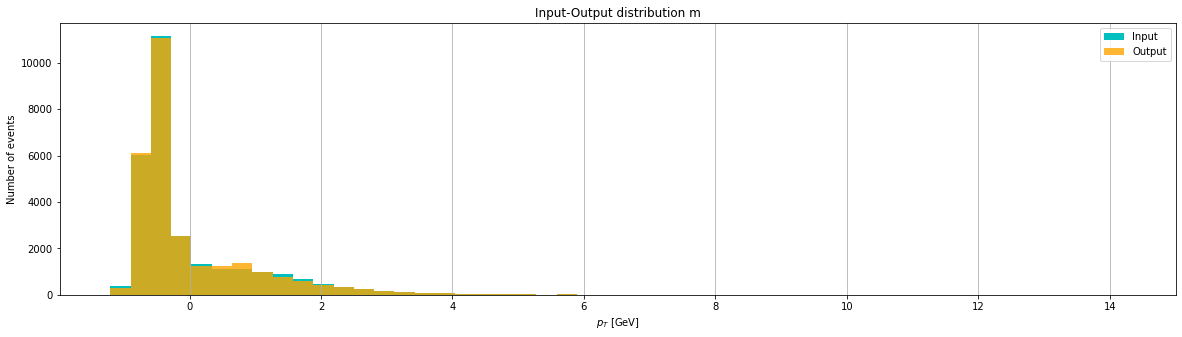

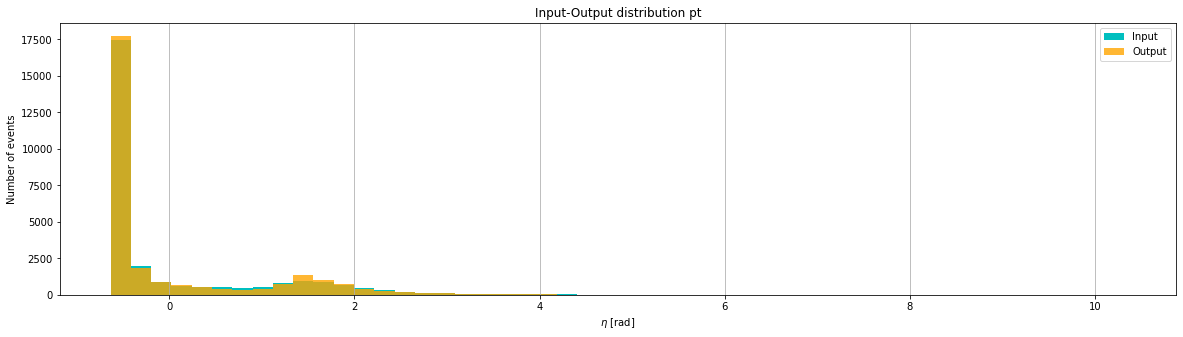

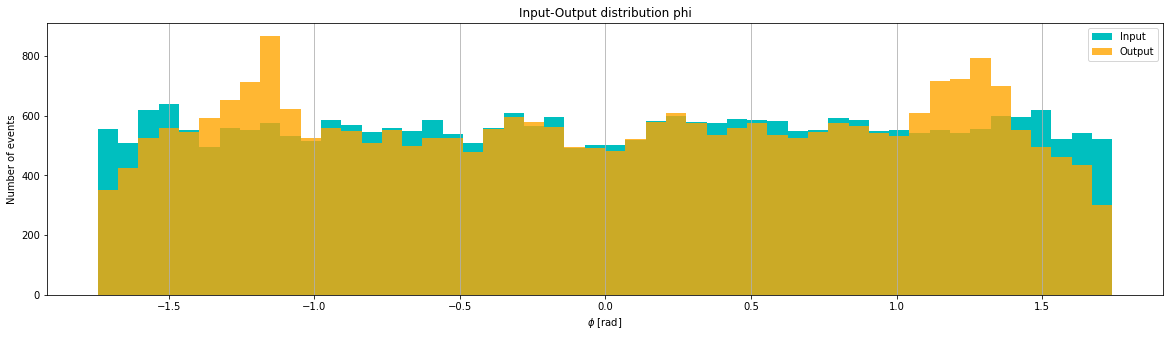

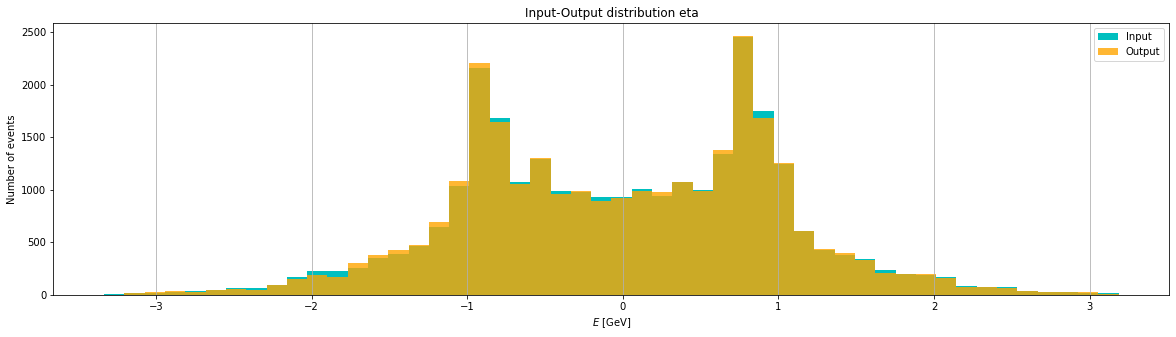

In [19]:
# Close previous Plots
plt.close('all')

# Define data variables
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

# Define data variable units
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']

# Other graph params
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.8
n_bins = 50

for idx in np.arange(4):
    fig_name = "Input-Output distribution " + train.columns[idx]
    plt.figure(figsize=[20,5])
    
    # Plot input histogram
    n_hist_data, bin_edges, _ = plt.hist(data[:,idx], color=colors[1], label='Input', alpha=1, bins=n_bins)
    
    # Plot output histogram
    n_hist_pred, _, _ = plt.hist(recon[:,idx], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    
    # Set misc. graph setings
    plt.title(fig_name)                                    # Set title
    plt.xlabel(variable_list[idx] + ' ' + unit_list[idx])  # Set label for x-axis
    plt.ylabel('Number of events')                         # Set label for y-asix
    plt.grid(axis='x')                                     # Set grid
    plt.legend()                                           # Set legend
    
    # Save figures
    #plt.savefig("graphs/Input-Output_distribution_" + train.columns[idx] + ".png", dpi=200)
    
    # Show figures
    plt.show()

Plotting residuals:

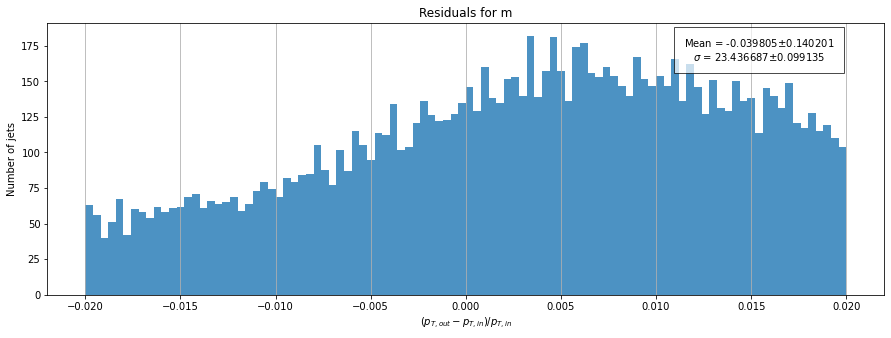

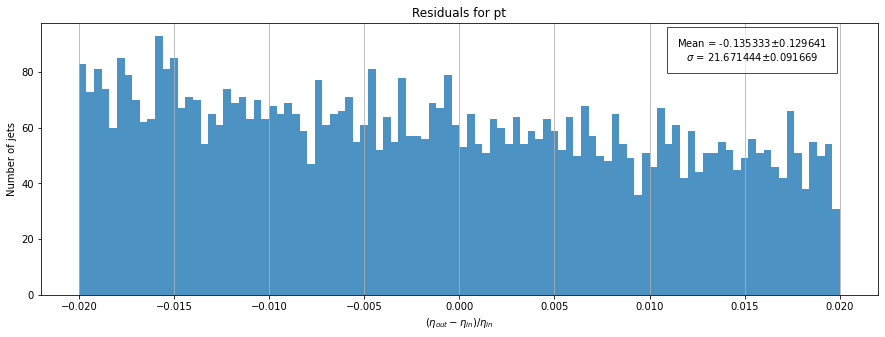

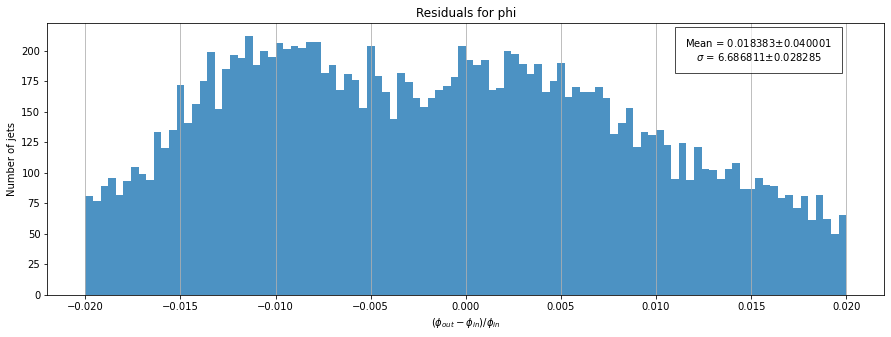

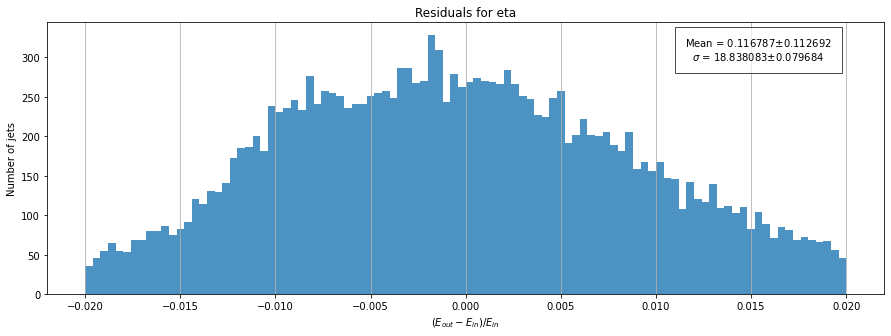

In [20]:
def std_error(x, axis=None, ddof=0):
    return np.nanstd(x, axis=axis, ddof=ddof) / np.sqrt(2 * len(x))

from scipy import stats

# Labels for x-axes
residual_strings = [
                r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                r'$(E_{out} - E_{in}) / E_{in}$'
            ]

# Calculate residuals
residuals = (recon - data.detach().numpy()) / data.detach().numpy()
resRange = (-.02, .02)

for idx in np.arange(4):
    plt.figure(figsize=[15,5])
    
    # Plot residual histograms.
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, idx], 
        label='Residuals', 
        linestyle=line_style[0], 
        alpha=alph, 
        bins=100, 
        range=resRange
    )
    
    # Set misc. graph setings
    fig_name = 'Residuals for ' + train.columns[idx]
    plt.title(fig_name)
    plt.xlabel(residual_strings[idx]) 
    plt.ylabel('Number of jets')
    plt.grid(axis='x')

    # Calculate residual statistics for text box
    std = np.std(residuals[:, idx])                       # Get standard-dev
    std_err = std_error(residuals[:, idx])          # Get standard error in standard-dev
    mean = np.nanmean(residuals[:, idx])                  # Get mean
    sem = stats.sem(residuals[:, idx], nan_policy='omit') # Get standard error of mean
    ax = plt.gca()
    
    # Add text box with stats
    plt.text(
        .85, .9, 
        'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), 
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes, 
        fontsize=10
    )
    
    # Save Graph
    #plt.savefig("graphs/Residuals_" + train_x.columns[idx] + ".png", dpi=200)

    # Show Graph
    plt.show()

# Observations:



*   Since the model generalises well to the test set, we can conclude that the distribution of the train and test set are quite similar.
*   The model finds it hard to match the distribution at edge values, particularly for Number of Jets versus Phi.
*   Enaling batch norm makes training a bit more stable, and reduces the average test MSE loss, but causes a more significant distribution mismatch at the edge values.
*   The residuals are mostly centred around zero, also pointing towards the performance of the model with respect to the reconstruction loss.
*   The plot for test MSE loss is quite noisy but with a low average value, indicating that the model does well on most samples, but is off the mark for a few outliers.
